## 1. General data checking and cleaning

In [1]:
!pip install missingno

In [2]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 106.9 MB/s eta 0:00:00


In [3]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 130.9 MB/s eta 0:00:00


In [4]:
!pip install openpyxl

### 1.1 Prepare the dataset

In [7]:
%%bash
dx download "UKB Metabolomics:/agarham/participant_dataset.tsv"

In [8]:
%%bash
dx download "UKB Metabolomics:/imputation/qrilc_imputed_metabolomics_v2.csv"

In [10]:
%%bash
dx download "UKB Metabolomics:/agarham/psoriasis_severity1y_icdgpmed.tsv"

In [11]:
%%bash
dx download "UKB Metabolomics:/agarham/psa_diagnoses_v2.tsv"

In [12]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import pandas as pd
import numpy as np

df = pd.read_csv('participant_dataset.tsv', sep = '\t')
df.shape

(501966, 463)

For memory and time efficiency, here we create a random subset using only 10% of the real data. 
This subset is used for trial purposes, before running with the whole dataset.

In [13]:
# Create a random subset of the dataset 

# subset = df.sample(frac=0.1, replace=False, random_state=1)
# subset.to_csv('participant_dataset_subset.csv', index=False)  

In [14]:
# %%bash
# dx upload 'participant_dataset_subset.tsv'

If needed, for running outside of the cloud (in local machine), create a synthetic data representing the real data.

In [15]:
# from sdv.tabular import GaussianCopula
# import pandas as pd

# Fit the model on real data
# model = GaussianCopula()
# model.fit(subset)

# # Generate synthetic data
# synthetic_data = model.sample()

# synthetic_data.head()

Now, we are slicing the dataset for participants with available metabolomics, and create a dataframe containing the selected covariates only.

In [17]:
# Load the metabolomics dataset
met_df = pd.read_csv('qrilc_imputed_metabolomics_v2.csv')
met_df.shape

(268048, 250)

In [18]:
# Slice to metabolomics available dataset only
df = df[df['eid'].isin(met_df['eid'])]
df.shape

(268048, 463)

In [19]:
# Create a list of columns to be selected
base_cols = ['eid', # Participant IDs
             '74-0.0', # Fasting time
             '31-0.0', # Sex
             '21001-0.0', # BMI
             '20116-0.0', # Smoking status
             '21003-0.0', # Age at participation
             '54-0.0' # Assessment centre
            ]

# Create a list of column names
base_names = ['eid',
              'fast',
              'sex',
              'bmi',
              'smo',
              'age',
              'cent'
             ]

# Create a dictionary to pair the old column names with the new column names
base_cols_map = dict(zip(base_cols, base_names))

# Select and rename the columns
baseline_df = df[base_cols].rename(columns=base_cols_map)
baseline_df.shape

(268048, 7)

### 1.2. Clean up ethnicity data, self-reported medication, and smoking status

Ethnicity was recorded during the initial visit and repeats. Some participants who did not answer during the initial visit answered during the repeats. Because ethnicity doesn't change, we can fill the missing data in the initial visit with the repeats. Here, we code caucasians into 1, and other ethnicities into 0 (https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=1001). We do not need to recode those answering do not know (-1) or prefer not to answer (-3) as we only care about the caucasian ethnicity to select.

In [20]:
# Create function to perform the recoding
def recode(df, columns, old_codes):
    # Condition: Check if any of the specified columns contain the old codes
    condition = df[columns].isin(old_codes).any(axis=1)
    # Use np.select to assign 1 if condition is True, else 0
    recoded = np.select([condition], [1], default= 0)
    
    return recoded


#Recode ethnicity
# Create lists of the columns to be recoded
eth_cols = ['21000-0.0', '21000-1.0', '21000-2.0']

# Recode and add the recoded columns into the baseline data frame
baseline_df['eth'] = recode(df, eth_cols, [1, 1001, 1002, 1003]) # Codes for Caucasian: 1, 1001, 1002, or 1003

# Check number of ethnicity
print(f"Caucasian ethnicity: {(baseline_df['eth'] == 1).sum()}")

Caucasian ethnicity: 253924


Self reported medication is separated for female (data field 6153) and male (data field 6177). 
Touchscreen question "Do you regularly take any of the following medications? (you can select more than one answer)".
The answers were coded as 1, if the participant used cholesterol lowering medication (https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=100625).
Here we create a new variable 'meds' combining both data fields. Participants who answered 1 in any of these data fields are coded as 1, others as 0. For those answering do not know (-1) or prefer not to answer (-3) are coded as missing (NaN) and will be imputed later.

In [21]:
# Define medication columns
med_cols = ['6153-0.0', '6177-0.0']

# Identify rows with -1 or -3 
def contains_invalid(val):
    if isinstance(val, str):
        return any(x in val.split('|') for x in ['-1', '-3'])
    return val in [-1, -3]

# Create a mask
invalid_mask = df[med_cols].applymap(contains_invalid).any(axis=1)

# Recode presence of '1' to indicate lipid medication use
def contains_1(val):
    if isinstance(val, str):
        return '1' in val.split('|')
    return False

for col in med_cols:
    df[col] = df[col].apply(contains_1).astype(int)

# Recode and assign
baseline_df['meds'] = recode(df, med_cols, [1])

# Apply NaN to 'meds' where original values are -1 or -3
baseline_df.loc[invalid_mask, 'meds'] = np.nan

# Check results
print(f"NaNs in meds: {baseline_df['meds'].isna().sum()}")
print(f"On lipid medication: {(baseline_df['meds'] == 1).sum()}")

NaNs in meds: 2059
On lipid medication: 47660


Smoking questionnaire allows participants to choose "prefer not to answer" which was coded as -3 (https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=90). We will recode these values into NaN.

In [22]:
# Check number of -1 and -3 codes before replacement
print('before replacement:')
print(baseline_df['smo'].value_counts())

# Replace -1 and -3 codes in smo to NaN
baseline_df['smo'] = baseline_df['smo'].replace([-1, -3], np.nan)

# Correct the data types
baseline_df['smo'] = baseline_df['smo'].astype('Int64')
print(baseline_df['smo'].dtypes)

# Check the result
print('after replacement:')
print(baseline_df['smo'].value_counts())

before replacement:
smo
 0.0    145812
 1.0     92824
 2.0     28106
-3.0      1073
Name: count, dtype: int64
Int64
after replacement:
smo
0    145812
1     92824
2     28106
Name: count, dtype: Int64


### 1.3. Imputation of covariates

In [23]:
# Prepare the dataset
to_impute = baseline_df.merge(met_df, on = 'eid')
eid = to_impute['eid']

# Drop EID (not needed / do not contain any information for the imputation)
to_impute = to_impute.drop(columns=['eid'])

# Check missingness
print('proportion of missing values (%):')
print(to_impute[['sex', 'bmi', 'smo', 'age', 'cent', 'eth', 'meds']].isnull().sum() * 100 / len(to_impute))

proportion of missing values (%):
sex     0.000000
bmi     0.369337
smo     0.487226
age     0.000000
cent    0.000000
eth     0.000000
meds    0.768146
dtype: float64


<Axes: >

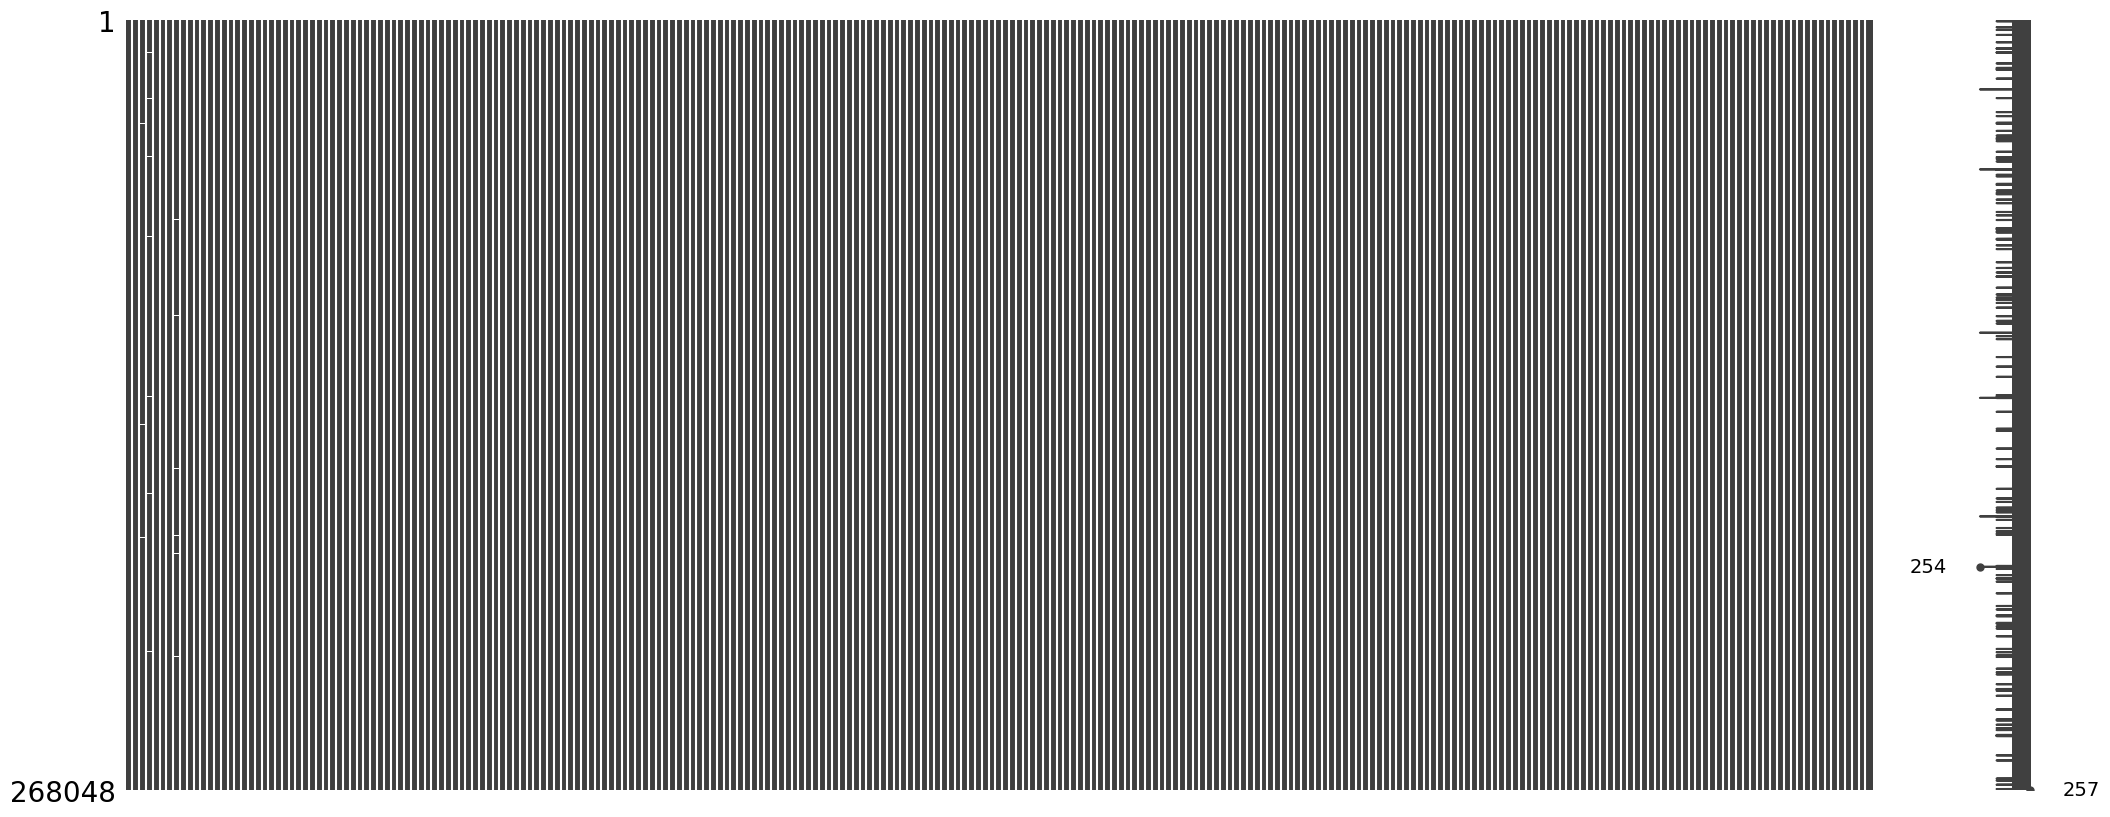

In [24]:
# Check the missingness visually
import missingno as msno
msno.matrix(to_impute)

In [ ]:
# Impute the dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
    
imputer = IterativeImputer(random_state=0, max_iter = 5)
imputed = imputer.fit_transform(to_impute)
imputed_df = pd.DataFrame(imputed, columns = to_impute.columns)

In [ ]:
# Check the imputation result visually
msno.matrix(imputed_df)

In [ ]:
# Check the imputation result
print('proportion of missing values (%):')
print(imputed_df[['bmi', 'smo', 'meds']].isnull().sum() * 100 / len(imputed_df))

In [ ]:
# Transfer back the eid
imputed_df['eid'] = eid

# Changing data types for smo (the imputation changes the datatype into float)
imputed_df['smo'] = imputed_df['smo'].astype('int64').astype('category')
imputed_df['meds'] = imputed_df['meds'].astype('int64').astype('category')

# Save the output
imputed_df.to_csv('final_imputed_dataset_v2.csv', index = False)

In [ ]:
%%bash
dx upload "UKB Metabolomics:/agarham/final_imputed_dataset_v2.csv"

In [ ]:
# Define function to evaluate the imputation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def compare_imputed_vs_original(original_df, imputed_df, columns, var_type='continuous', pdf_filename='comparison_plots.pdf'):
    with PdfPages(pdf_filename) as pdf:
        for col in columns:
            plt.figure(figsize=(6, 4))
            
            if var_type == 'continuous':
                sns.kdeplot(original_df[col].dropna(), label='Original (non-missing)', fill=True)
                sns.kdeplot(imputed_df[col], label='Imputed', fill=True)
                plt.title(f'Distribution for {col}')
            
            elif var_type == 'categorical':
                orig_counts = original_df[col].dropna().value_counts(normalize=True)
                imp_counts = imputed_df[col].value_counts(normalize=True)
                compare_df = pd.DataFrame({'Original': orig_counts, 'Imputed': imp_counts}).fillna(0)
                compare_df.plot(kind='bar', ax=plt.gca())
                plt.title(f'Category distribution for {col}')
                plt.ylabel('Proportion')
            
            plt.legend()
            plt.tight_layout()
            pdf.savefig() 
            plt.close()
            
# Perform imputation visual evaluation
compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['bmi'],
                            var_type='continuous',
                            pdf_filename='imputation - bmi.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['smo'],
                            var_type='categorical',
                            pdf_filename='imputation - smo.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['meds'],
                            var_type='categorical',
                            pdf_filename='imputation - meds.pdf'
                           )

In [ ]:
%%bash
dx upload "imputation - bmi.pdf" "imputation - smo.pdf" "imputation - meds.pdf"

### 1.4. Define prevalent cases

The date of first occurrence contains some pseoudodates (https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=819). The number of participants having these pseudodates are low, e.g. for psoriasis out of 16,221 cases, only 14 have these codes. We assume that these codes are caused by some imputation error, thus we replace these values to NaN.

In [25]:
%%bash
dx download "UKB Metabolomics:/agarham/final_imputed_dataset_v2.csv"

<Axes: >

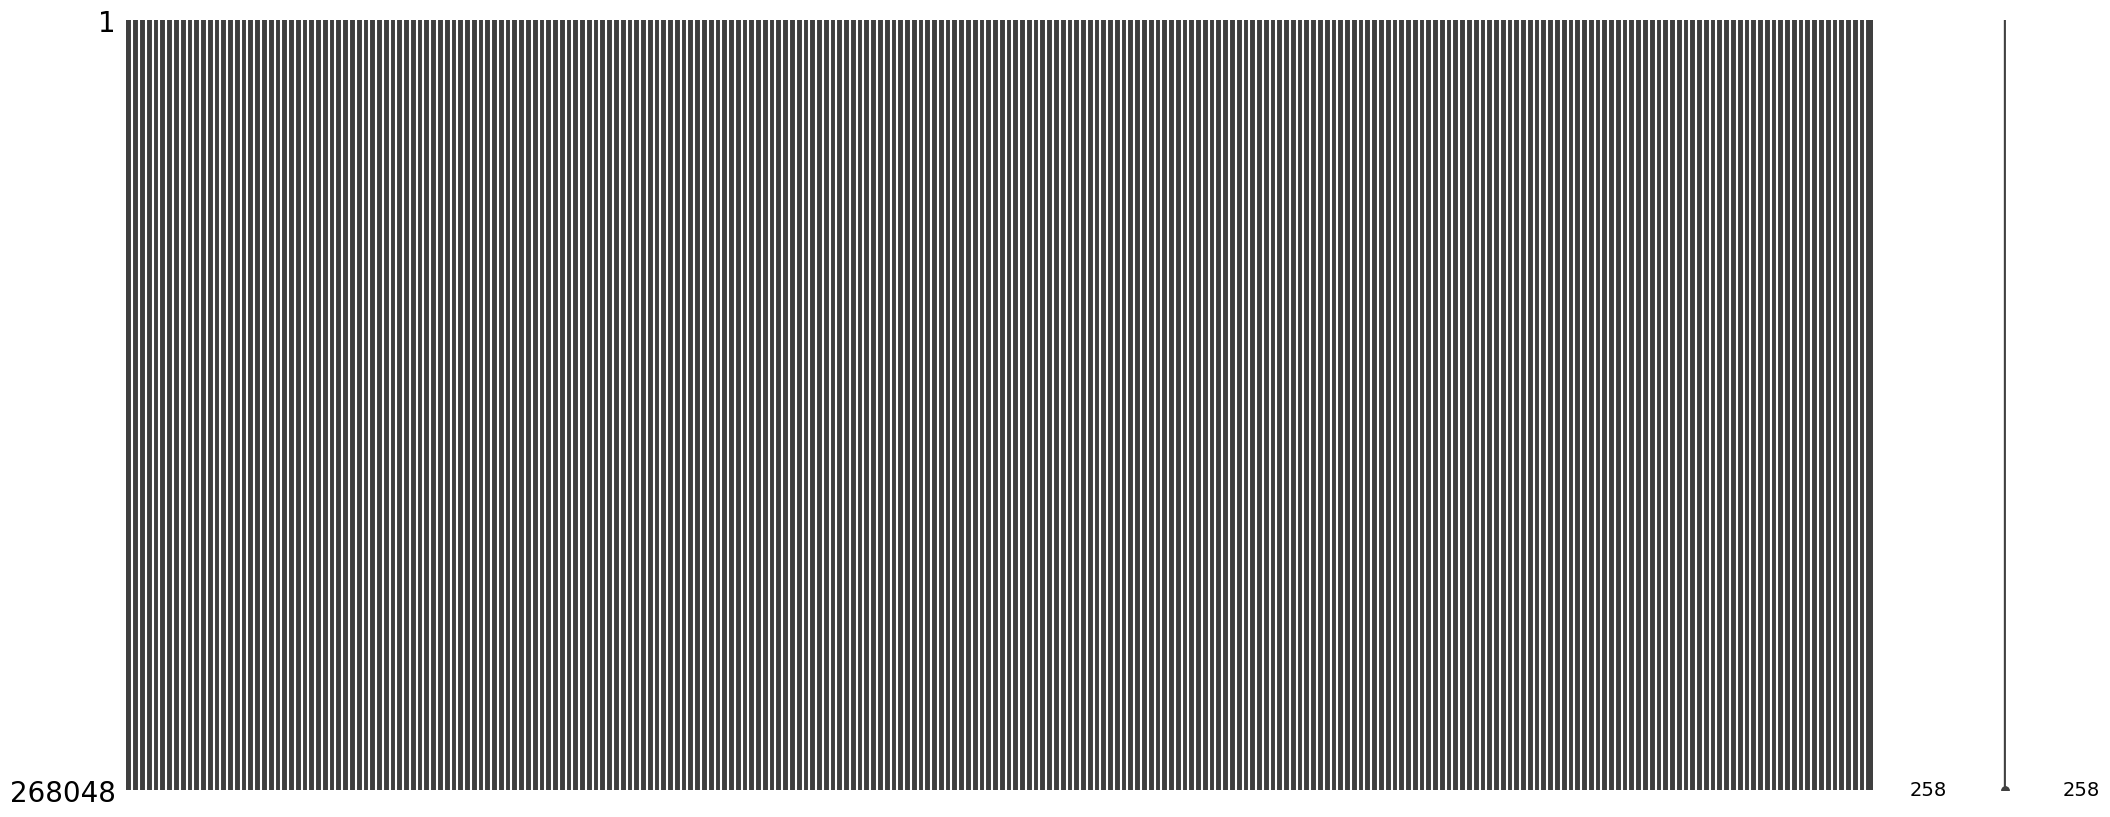

In [26]:
# To skip the imputation part, load the imputed dataset (saved after imputation)
imputed_df = pd.read_csv('final_imputed_dataset_v2.csv')

# Visualize the fully imputed dataset
msno.matrix(imputed_df)

In [27]:
# Assigning the imputed_df as the baseline_df
baseline_df = imputed_df.copy()

In [28]:
# Create a list of columns containing dates
attendance_date = ['53-0.0']

first_occurrence_date = ['131742-0.0', #first occurrence date for pso
                         '131720-0.0', #first occurrence date for ad
                         '131894-0.0', #first occurrence date for sle
                         '131848-0.0', #first occurrence date for ra (ICD-10 M05)
                         '131850-0.0', #first occurrence date for ra (ICD-10 M06)
                         '131626-0.0', #first occurrence date for cd
                         '131628-0.0', #first occurrence date for uc
                         '131912-0.0'  #first occurrence date for spa
                        ]

# Change data type to datetime 
df[attendance_date + first_occurrence_date] = df[attendance_date + first_occurrence_date].apply(pd.to_datetime)

In [29]:
# Create a list of the pseudodates to replace with NaN
pseudodates = [pd.to_datetime('1900-01-01'), # Code has no event date
               pd.to_datetime('1901-01-01'), # Code has event date before participant's date of birth
               pd.to_datetime('1902-02-02'), # Code has event date matching participant's date of birth
               pd.to_datetime('1903-03-03'), # Code has event date after participant's date of birth and falls in the same calendar year as date of birth
               pd.to_datetime('1909-09-09'), # Code has event date in the future and is presumed to be a place-holder or other system default
               pd.to_datetime('2037-07-07') # Code has event date in the future and is presumed to be a place-holder or other system default
              ]

# Replace the pseudodates with NaN 
df[attendance_date + first_occurrence_date] = df[attendance_date + first_occurrence_date].replace(pseudodates, np.nan)

# Check if the pseudodates are successfully replaced
pseudodates_remains = df[attendance_date + first_occurrence_date].isin(pseudodates).sum().sum()

# Print the count of True values
print(f"Number of pseudodates: {pseudodates_remains}")

Number of pseudodates: 0


Prevalent psoriasis cases are defined as first occurrence date before attending the assessment centre. RA can be defined by 2 ICD-10 codes, M05 and M06.

In [30]:
imids = ['pso', 'ad', 'sle', 'ra_m05','ra_m06', 'cd', 'uc', 'spa']

for i, col in enumerate(first_occurrence_date):
    baseline_df[imids[i]] = np.where((df[col] <= df['53-0.0']) & (df[col].notnull()), 1, 0)
    print(f"Number of prevalent {imids[i]} cases: {(baseline_df[imids[i]] == 1).sum()}")
    
# Combine RA M05 and RA M05 
baseline_df['ra'] = recode(baseline_df, ['ra_m05','ra_m06'], [1])
print(f"Number of prevalent ra cases: {(baseline_df['ra'] == 1).sum()}")

Number of prevalent pso cases: 6131
Number of prevalent ad cases: 5373
Number of prevalent sle cases: 403
Number of prevalent ra_m05 cases: 208
Number of prevalent ra_m06 cases: 3694
Number of prevalent cd cases: 1134
Number of prevalent uc cases: 2283
Number of prevalent spa cases: 840
Number of prevalent ra cases: 3705


Definition of psoriatic arthritis and severe psoriasis has been done separately.

In [31]:
# Loading psoriatic arthritis and severity dataset
psa = pd.read_csv('psa_diagnoses_v2.tsv', sep = '\t') 
sev = pd.read_csv('psoriasis_severity1y_icdgpmed.tsv', sep = '\t')
sev.rename(columns={'sev1y': 'sev_pso'}, inplace=True) # Rename column to match the rest of the codes

# Define prevalent psoriatic arthritis
psa = df[['eid', '53-0.0']].merge(psa, how='inner', on='eid')
psa['pre_psa'] = (psa['psa_date'] < psa['53-0.0']).astype(int)
psa['inc_psa'] = (psa['psa_date'] > psa['53-0.0']).astype(int) # just to check incident psa

# Add psa and sev to baseline df
baseline_df = baseline_df.merge(psa[['eid', 'pre_psa']], how='inner', on='eid')
baseline_df = baseline_df.merge(psa[['eid', 'inc_psa']], how='inner', on='eid')
baseline_df = baseline_df.merge(sev[['eid', 'sev_pso']], how='inner', on='eid')

# Check numbers
print(f"Number of prevalent psa cases: {(baseline_df['pre_psa'] == 1).sum()}")
print(f"Number of incident psa cases: {(baseline_df['inc_psa'] == 1).sum()}")
print(f"Number of prevalent severe cases: {(baseline_df['sev_pso'] == 1).sum()}")

Number of prevalent psa cases: 210
Number of incident psa cases: 657
Number of prevalent severe cases: 1860


In [32]:
# Create a new variable for psoriatic arthritis vs non-psoriatic arthritis
baseline_df['psa_non_psa'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 1), 'psa_non_psa'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 0), 'psa_non_psa'] = int(0)
baseline_df.loc[baseline_df['pso'] == 0, 'psa_non_psa'] = np.nan

# Create a new variable for psoriatic arthritis vs non-psoriasis
baseline_df['psa'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 1), 'psa'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 0), 'psa'] = np.nan
baseline_df.loc[baseline_df['pso'] == 0, 'psa'] = int(0)

# Create a new variable for non-psoriatic arthritis vs non-psoriasis
baseline_df['non_psa'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 1), 'non_psa'] = np.nan
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 0), 'non_psa'] = int(1)
baseline_df.loc[baseline_df['pso'] == 0, 'non_psa'] = int(0)

# Check numbers of cases
print(f'number of prevalent psa and non psa cases:')
print(baseline_df['psa_non_psa'].value_counts())

number of prevalent psa and non psa cases:
psa_non_psa
0.0    5921
1.0     210
Name: count, dtype: int64


In [33]:
# Create a new variable for non-severe prevalent psoriasis
baseline_df['sev_non_sev'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 1), 'sev_non_sev'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 0), 'sev_non_sev'] = int(0)
baseline_df.loc[(baseline_df['pso'] == 0), 'sev_non_sev'] = np.nan

# Create a new variable for severe prevalent psoriasis
baseline_df['sev'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 1), 'sev'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 0), 'sev'] = np.nan
baseline_df.loc[(baseline_df['pso'] == 0), 'sev'] = int(0)

# Create a new variable for non-severe prevalent psoriasis
baseline_df['non_sev'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 1), 'non_sev'] = np.nan
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 0), 'non_sev'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 0), 'non_sev'] = int(0)

# Check numbers of cases
print(f'number of prevalent severe and non severe psoriasis:')
print(baseline_df['sev_non_sev'].value_counts())

number of prevalent severe and non severe psoriasis:
sev_non_sev
0.0    5725
1.0     406
Name: count, dtype: int64


Number is different than sev_pso as there are participant with self-reported medication use that are not prevalent psoriasis cases.

## 2. Metabolomics dataset checking and pre-processing

### 2.1. Data types check

In [34]:
# Check data types for each column
def check_dtype(data):
    int_dtype = []
    flo_dtype = []
    cat_dtype = []
    oth_dtype = []

    for column, dtype in data.dtypes.items():
        if dtype == 'int64':
            int_dtype.append(column)
        elif dtype == 'float64':
            flo_dtype.append(column)
        elif dtype == 'category':
            cat_dtype.append(column)
        else:
            oth_dtype.append(column)

    return int_dtype, flo_dtype, cat_dtype, oth_dtype

int_dtype, flo_dtype, cat_dtype, oth_dtype = check_dtype(baseline_df)

print(f"Columns with integer data type: {int_dtype}")
print(f"Columns with float data type: {flo_dtype}")
print(f"Columns with categorical data type: {cat_dtype}")
print(f"Columns with other data type: {oth_dtype}")

Columns with integer data type: ['smo', 'meds', 'eid', 'pso', 'ad', 'sle', 'ra_m05', 'ra_m06', 'cd', 'uc', 'spa', 'ra', 'pre_psa', 'inc_psa', 'sev_pso']
Columns with float data type: ['fast', 'sex', 'bmi', 'age', 'cent', 'eth', 'Acetate', 'Acetoacetate', 'Acetone', 'Ala', 'Albumin', 'ApoA1', 'ApoB', 'ApoB_by_ApoA1', 'bOHbutyrate', 'Cholines', 'Citrate', 'Clinical_LDL_C', 'Creatinine', 'DHA', 'DHA_pct', 'Gln', 'Glucose', 'Gly', 'GlycA', 'HDL_C', 'HDL_CE', 'HDL_FC', 'HDL_L', 'HDL_P', 'HDL_PL', 'HDL_size', 'HDL_TG', 'His', 'IDL_C', 'IDL_C_pct', 'IDL_CE', 'IDL_CE_pct', 'IDL_FC', 'IDL_FC_pct', 'IDL_L', 'IDL_P', 'IDL_PL', 'IDL_PL_pct', 'IDL_TG', 'IDL_TG_pct', 'Ile', 'L_HDL_C', 'L_HDL_C_pct', 'L_HDL_CE', 'L_HDL_CE_pct', 'L_HDL_FC', 'L_HDL_FC_pct', 'L_HDL_L', 'L_HDL_P', 'L_HDL_PL', 'L_HDL_PL_pct', 'L_HDL_TG', 'L_HDL_TG_pct', 'L_LDL_C', 'L_LDL_C_pct', 'L_LDL_CE', 'L_LDL_CE_pct', 'L_LDL_FC', 'L_LDL_FC_pct', 'L_LDL_L', 'L_LDL_P', 'L_LDL_PL', 'L_LDL_PL_pct', 'L_LDL_TG', 'L_LDL_TG_pct', 'L_VLDL_C',

In [35]:
# Change data types for columns with wrong data types
# Define the conversion dictionary
convert_dict = {
    # Integers
    'age': 'int64', 'sex': 'int64', 'eth': 'int64', 'meds': 'int64',
    'eid': 'int64', 'pso': 'int64', 'ad': 'int64', 'sle': 'int64',
    'ra_m05': 'int64', 'ra_m06': 'int64', 'cd': 'int64', 'uc': 'int64',
    'spa': 'int64', 'ra': 'int64', 
    
    # Float (to contain NaNs)
    'pre_psa': 'float64', 'inc_psa': 'float64', 'sev_pso': 'float64', 
    'psa_non_psa': 'float64', 'psa': 'float64', 'non_psa': 'float64',
    'sev_non_sev': 'float64', 'sev': 'float64', 'non_sev': 'float64',
    
    # Category
    'cent': 'category',
    'smo': 'category'
}



# Convert columns using the dictionary
baseline_df = baseline_df.astype(convert_dict)

# Check results
int_dtype, flo_dtype, cat_dtype, oth_dtype = check_dtype(baseline_df)

print(f"Columns with integer data type: {int_dtype}")
print(f"Columns with float data type: {flo_dtype}")
print(f"Columns with categorical data type: {cat_dtype}")
print(f"Columns with other data type: {oth_dtype}")

Columns with integer data type: ['sex', 'age', 'eth', 'meds', 'eid', 'pso', 'ad', 'sle', 'ra_m05', 'ra_m06', 'cd', 'uc', 'spa', 'ra']
Columns with float data type: ['fast', 'bmi', 'Acetate', 'Acetoacetate', 'Acetone', 'Ala', 'Albumin', 'ApoA1', 'ApoB', 'ApoB_by_ApoA1', 'bOHbutyrate', 'Cholines', 'Citrate', 'Clinical_LDL_C', 'Creatinine', 'DHA', 'DHA_pct', 'Gln', 'Glucose', 'Gly', 'GlycA', 'HDL_C', 'HDL_CE', 'HDL_FC', 'HDL_L', 'HDL_P', 'HDL_PL', 'HDL_size', 'HDL_TG', 'His', 'IDL_C', 'IDL_C_pct', 'IDL_CE', 'IDL_CE_pct', 'IDL_FC', 'IDL_FC_pct', 'IDL_L', 'IDL_P', 'IDL_PL', 'IDL_PL_pct', 'IDL_TG', 'IDL_TG_pct', 'Ile', 'L_HDL_C', 'L_HDL_C_pct', 'L_HDL_CE', 'L_HDL_CE_pct', 'L_HDL_FC', 'L_HDL_FC_pct', 'L_HDL_L', 'L_HDL_P', 'L_HDL_PL', 'L_HDL_PL_pct', 'L_HDL_TG', 'L_HDL_TG_pct', 'L_LDL_C', 'L_LDL_C_pct', 'L_LDL_CE', 'L_LDL_CE_pct', 'L_LDL_FC', 'L_LDL_FC_pct', 'L_LDL_L', 'L_LDL_P', 'L_LDL_PL', 'L_LDL_PL_pct', 'L_LDL_TG', 'L_LDL_TG_pct', 'L_VLDL_C', 'L_VLDL_C_pct', 'L_VLDL_CE', 'L_VLDL_CE_pct', '

In [36]:
# Generate a summary report
# from ydata_profiling import ProfileReport

# covariates = baseline_df[['age', 'sex', 'bmi', 'eth', 'smo', 'meds', 'cent', 'pso', 'pso_art', 'sev_pso', 'ad', 'sle', 'cd', 'uc', 'as', 'ra']]
# profile = ProfileReport(covariates)

# # Export report to html
# profile.to_file("covariates_report.html")

### 2.2. Correlation and multicollinearity

We will check correlation between the covariates, to see if there is any multicollinearity. Multicollinearity occurs when two or more independent variables (predictors) are highly correlated with each other. This can create problems in linear regression models because when two predictors are strongly correlated, the model struggles to determine which variable is actually influencing the dependent variable. If two variables provide the same information, it becomes difficult to understand their individual effects on the dependent variable.

In [37]:
# Check if two independent variables have a correlation > 0.8 (high correlation).
cols_to_check = ['age', 'sex', 'bmi', 'eth', 'smo', 'meds', 'cent', 'pso', 'psa', 'sev', 'ad', 'sle', 'cd', 'uc', 'ra']
matrix = baseline_df[cols_to_check].corr(numeric_only=True)

print("Correlation matrix : ")
print(matrix)

Correlation matrix : 
           age       sex       bmi       eth      meds       pso       psa  \
age   1.000000  0.021336  0.044936  0.114647  0.273972  0.006671  0.000701   
sex   0.021336  1.000000  0.078447 -0.006648  0.132735  0.015037  0.003395   
bmi   0.044936  0.078447  1.000000 -0.019781  0.185367  0.025167  0.016248   
eth   0.114647 -0.006648 -0.019781  1.000000 -0.007587  0.015532  0.000106   
meds  0.273972  0.132735  0.185367 -0.007587  1.000000  0.015497  0.009825   
pso   0.006671  0.015037  0.025167  0.015532  0.015497  1.000000  1.000000   
psa   0.000701  0.003395  0.016248  0.000106  0.009825  1.000000  1.000000   
sev   0.000898  0.003992  0.017850  0.000262  0.007648  1.000000  1.000000   
ad   -0.001702 -0.011091  0.002009 -0.000463 -0.000397  0.026726  0.001863   
sle  -0.004023 -0.026183 -0.003280 -0.010673  0.003857  0.000504  0.002382   
cd    0.001701 -0.001970 -0.007025  0.006111  0.003652  0.009251  0.004467   
uc    0.011527  0.006999 -0.002026  0.0049

The correlation matrix only shows pairwise (one-to-one) correlations between two variables at a time.
VIF measures how much a variable is explained by all other independent variables together (multi-variable collinearity).
Pairwise correlations may be low, but a variable can still be linearly dependent on a combination of multiple variables, which is what VIF captures.

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data['feature'] = cols_to_check

X = baseline_df[cols_to_check].dropna() # VIF cannot handle NaNs
X_numeric = pd.get_dummies(X, drop_first=True).astype('int64') # VIF cannot handle categorical variables

# calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i)
                          for i in range(len(cols_to_check))]

print(vif_data)

   feature        VIF
0      age  34.946247
1      sex   1.904569
2      bmi  24.489594
3      eth  18.058164
4      smo   1.321341
5     meds        inf
6     cent        inf
7      pso        inf
8      psa   1.032623
9      sev   1.003430
10      ad   1.031517
11     sle   1.036388
12      cd   1.021046
13      uc   1.684377
14      ra   1.195078


### 2.2. Normality check

We will check the normality of the columns containing continuous data types using 1) visual inspection in histogram, and 2) using Kolgomorov-Smirnov test.

In [40]:
import math
from scipy.stats import kstest

met_names = met_df.columns[1:]

# Function to apply the KS test on a single column
def ks_pvalue(col):
    return kstest(col, 'norm').pvalue

# Apply the function to all continuous columns
pvalues = baseline_df[met_names].apply(ks_pvalue)

# if p-value < 0.05, sufficient evidence that the data does not come from a normal distribution
# Check for any columns having p-value > 0.05 (normally distributed)
print(pvalues[pvalues > 0.05])

Series([], dtype: float64)


In [41]:
def create_histogram(title, data):
    # Define number of histograms per page 
    histograms_per_page = 20
    columns_per_page = 4  
    rows_per_page = 5 

    # Create a PDF to save all the histograms
    from matplotlib.backends.backend_pdf import PdfPages
    pdf_pages = PdfPages(f'{title} - histogram.pdf')

    # Plot the metabolites in loop
    for start in range(0, len(data.columns), histograms_per_page):
        fig, axes = plt.subplots(nrows=columns_per_page, ncols=rows_per_page, figsize=(8.27, 11.69))  # A4 size
        axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate over

        for i, col in enumerate(data.columns[start:start + histograms_per_page]):
            if i >= len(axes):
                break  # Prevent exceeding available axes
            axes[i].hist(data[col], bins=20, color='skyblue')
            axes[i].set_title(col, fontsize=8)  

        plt.tight_layout()
        pdf_pages.savefig(fig) 
        plt.close(fig)  
    pdf_pages.close()

In [42]:
# # Call the function to create histogram
# create_histogram(title='original_data', data=baseline_df[met_names])

In [43]:
# %%bash
# dx upload "original_data - histogram.pdf"

### 2.3. Outlier check and removal

Outliers can significantly affect linear regression models, especially in OLS. Outliers pulls the regression line toward them and distorting the slope.<br>
<br>
We remove outliers before transformation, because although transformation minimize the effect of outliers, it does not eliminate the influence of extreme outliers. The larger the value of the outlier, the more it still dominates the distribution, just less than before. We will apply log1p transformation to correct for mild skewness and minimize the effect of the remaining less extreme outliers. <br>
<br>
We use 4 IQR rule because: <br>
1). the data are non normally distributed <br>
2). the outliers are not symetric (towards the right / higher value) and far away from the majority of the data

In [44]:
# Define function to calculate the lower and upper bounds
def calculate_outlier_bounds(data, col, multiplier=4):
    """
    Calculate the outlier bounds for a given column using the IQR method.
    Returns lower and upper bounds for outlier detection.
    """
    # Calculate Q1, Q3, and IQR for the column
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    return lower_bound, upper_bound


# Function to create box plots and mark outliers
from matplotlib.backends.backend_pdf import PdfPages

def create_box_plots(title, data, multiplier=4):
    # Create a PDF to save all the box plots
    pdf_pages = PdfPages(f'{title} - box plot.pdf')
    
    # Loop through the columns in chunks
    for start in range(0, len(data.columns), 20):
        # Create a new figure for each set of box plots (4 rows, 5 columns per page)
        fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(8.27, 11.69))  # A4 size
        axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate over

        # Loop over the columns and create a box plot for each one
        for i, col in enumerate(data.columns[start:start + 20]):
            if i >= len(axes):
                break  # Prevent exceeding available axes
            
            lower_bound, upper_bound = calculate_outlier_bounds(data, col, multiplier)
            
            # Create the box plot
            axes[i].boxplot(data[col].dropna(), showfliers=False)
            axes[i].set_title(col, fontsize=8)  # Set the title to the column name (variable)
            
            # Highlight the outliers (values outside the IQR bounds)
            outliers = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]
            axes[i].scatter(np.ones(len(outliers)) * 1, outliers, color='red')  # Red dots for outliers
            
            # Display the number of outliers in the upper-right corner of the plot
            outlier_count = len(outliers)
            axes[i].text(0.95, 0.95, f'{outlier_count}', 
                         horizontalalignment='right', verticalalignment='top',
                         transform=axes[i].transAxes, fontsize=8, color='red')
            
            axes[i].set_xticklabels([])  # Remove x-tick labels

        # Adjust layout to prevent overlap and save this figure as a new page in the PDF
        plt.tight_layout()
        pdf_pages.savefig(fig)  # Save current figure to the PDF
        plt.close(fig)  # Close the figure to avoid memory issues

    # Close the PDF file after saving all pages
    pdf_pages.close()
    
    # Define a function to remove outliers based on the 4 * IQR rule, and fill in values with the lower / upper bounds
def remove_outliers(df, multiplier=4):
    # Copying the original data to avoid modifying it directly
    df_cleaned = df.copy()
    
    for col in df.columns:
        # Calculate the lower and upper bounds for outliers
        lower_bound, upper_bound = calculate_outlier_bounds(df, col, multiplier)
        
        # Identify non-outlier data
        data = df[col]
        cleaned_data = data[(data >= lower_bound) & (data <= upper_bound)]

        # Get min and max of cleaned data
        min_valid = cleaned_data.min()
        max_valid = cleaned_data.max()

        # Replace outliers
        data_clipped = data.copy()
        data_clipped[data > upper_bound] = max_valid
        data_clipped[data < lower_bound] = min_valid
        
        df_cleaned[col] = data_clipped
    
    return df_cleaned

In [45]:
# # Create boxplots to visualize outliers
# create_box_plots('outliers', baseline_df[met_names], multiplier=4)

# Apply outlier removal
df_no_outliers = remove_outliers(baseline_df[met_names], multiplier=4)

# # Create histograms to visualize the cleaned data
# create_histogram(title='cleaned', data=df_no_outliers)

In [46]:
# %%bash
# dx upload "outliers - box plot.pdf" "cleaned - histogram.pdf"

### 2.4. Data transformation

Based on the normality test, all variables seem to be non-normally distributed (skewed). To make it closer to normal (and minimize the effect of outliers), we transform the data using log1p transformation. <br>
 <br>
Log1p transformation avoids loss of precision that can occur when the value is very small (close to zero), which in our case, many of the metabolite values are very small. It still compress small positive numbers as in standard log transformation, but less aggressively. And if there are zero values, they still return the value to 0 (otherwise in standard log, it will be undefined/error).

In [47]:
# Apply log1p transformation
df_cleaned_transformed = df_no_outliers.apply(np.log1p)
df_uncleaned_transformed = baseline_df[met_names].apply(np.log1p)

# # Create histograms to visualize the transformed data
# create_histogram(title='cleaned_transformed', data=df_cleaned_transformed)
# create_histogram(title='uncleaned_transformed', data=df_uncleaned_transformed)

To make sure the data was successfully transformed we check the summary statistics before and after transformation.

In [48]:
# Function to summarize stats
from scipy.stats import skew

def summarize_stats(df):
    summary = pd.DataFrame({
        'mean': df.mean(),
        'variance': df.var(), # Log transformations compress large values, which typically reduces variance.
        'skewness': df.apply(skew, nan_policy='omit')
    })
    return summary

# Apply function to see the summary before and after transformation
before_transform = summarize_stats(df_no_outliers)
after_transform = summarize_stats(df_cleaned_transformed)

# Combine both summaries to compare
transform_comparison = pd.concat([before_transform.add_prefix('before_'), 
                                  after_transform.add_prefix('after_')], axis=1)

# Check how much the skewness changes
transform_comparison['skewness_change'] = transform_comparison['after_skewness'] - transform_comparison['before_skewness']

# Check the result
print(transform_comparison.describe())

transform_comparison.head()

       before_mean  before_variance  before_skewness  after_mean  \
count   249.000000     2.490000e+02       249.000000  249.000000   
mean      9.970728     5.724910e+00         0.469401    1.306381   
std      16.577049     2.101446e+01         0.766955    1.426543   
min       0.000002     2.345908e-12        -1.875386    0.000002   
25%       0.098483     1.215788e-03         0.254220    0.093476   
50%       0.667055     3.917594e-02         0.519144    0.509669   
75%      14.327705     2.339694e+00         0.996643    2.718560   
max      71.164543     2.268506e+02         1.912594    4.278700   

       after_variance  after_skewness  skewness_change  
count    2.490000e+02      249.000000       249.000000  
mean     1.631262e-02        0.110868        -0.358532  
std      3.116936e-02        0.876983         0.365830  
min      2.345895e-12       -3.240727        -2.110255  
25%      7.268292e-04       -0.144104        -0.478849  
50%      4.212485e-03        0.280398        

,before_mean,before_variance,before_skewness,after_mean,after_variance,after_skewness,skewness_change
Acetate,0.015884,0.000045,1.527782,0.015737,0.000043,1.483161,-0.044622
Acetoacetate,0.012661,0.000101,1.912594,0.012533,0.000097,1.875932,-0.036662
Acetone,0.014077,0.000020,1.856483,0.013969,0.000020,1.837988,-0.018495
Ala,0.292376,0.003646,0.609471,0.255407,0.002136,0.437897,-0.171574
Albumin,39.360274,8.463893,-0.056371,3.695218,0.005293,-0.303797,-0.247426


Skewness measures how asymmetric the data around its mean: <br>

Skewness = 0: Perfectly symmetrical (normally distributed) <br>
Skewness > 0 (Positive Skew): Right-tailed — Most data points are concentrated on the left, with a few extreme high values. <br>
Skewness < 0 (Negative Skew): Left-tailed — Most data points are concentrated on the right, with a few extreme low values.  <br>
<br>
0.1 to 0.5	Slight skew <br>
0.5 to 1	Moderate skew <br>
Above 1	Highly skewed <br>

Absolute change ≥ 0.5 is major (because skewness changes by 0.5 or more usually indicate the distribution shape improved significantly). <br>
Absolute change between 0.1 and 0.5 is moderate. <br>
Absolute change < 0.1 is negligible → likely already log-transformed or didn’t need transformation. <br>

Then, we check the normality again.

In [49]:
# # Call the function to create histogram
# create_histogram(title='log1p_transformed', data=df_cleaned_transformed)

# Call the KS test function
pvalues = df_cleaned_transformed.apply(ks_pvalue)

# if p-value < 0.05, sufficient evidence that the data does not come from a normal distribution
# Check for any columns having p-value > 0.05 (normally distributed)
print(pvalues[pvalues > 0.05])

Series([], dtype: float64)


In [50]:
# %%bash
# dx upload "log1p_transformed - histogram.pdf"

### 2.5. Scaling (z transformation)

To allow comparability of the effect size between metabolites, here we scale the metabolite data into standard deviation unit (z score).

In [51]:
# Transform values into z-score
import scipy.stats as stats

df_scaled = baseline_df[met_names].apply(stats.zscore, nan_policy='omit') # original data with outliers
df_cleaned_scaled = df_no_outliers.apply(stats.zscore, nan_policy='omit') # data without outliers
df_cleaned_transformed_scaled = df_cleaned_transformed.apply(stats.zscore, nan_policy='omit') # transformed data without outliers
df_uncleaned_transformed_scaled = df_uncleaned_transformed.apply(stats.zscore, nan_policy='omit') # transformed data with outliers

Then we check the scaling result by lookig at the range.

In [52]:
# Function to summarize stats
def range_stats(df):
    summary = pd.DataFrame({
        'min': df.min(),
        'max': df.max(),
        'range': abs(df.max()-df.min())
    })
    return summary

# Apply function to see the summary before and after transformation
before_scale = range_stats(df_cleaned_transformed)
after_scale = range_stats(df_cleaned_transformed_scaled)

# Combine both summaries to compare
scale_comparison = pd.concat([before_scale.add_prefix('before_'), 
                              after_scale.add_prefix('after_')], axis=1)

scale_comparison.head()

,before_min,before_max,before_range,after_min,after_max,after_range
Acetate,0.000000,0.046355,0.046355,-2.386419,4.642985,7.029404
Acetoacetate,0.000000,0.051440,0.051440,-1.272820,3.951310,5.224130
Acetone,0.002292,0.032434,0.030141,-2.642809,4.178773,6.821583
Ala,0.073489,0.497566,0.424077,-3.936275,5.239733,9.176008
Albumin,3.369153,4.052123,0.682970,-4.481720,4.905592,9.387312


Note: Here we only pre-process the metabolomics data. We do not scale the other covariates (age, bmi) as our focus is not the comparability between the variables, but across the metabolites. 

## 3. Association analysis

For the analysis, we select caucasian ethnicity only to make it comparable to HUNT dataset.

In [53]:
# Assign the pre-processed metabolomics data to the baseline_df
baseline_df = pd.concat([baseline_df,
                         #df_scaled.add_suffix('_sc'),
                         #df_cleaned_scaled.add_suffix('_clsc'),
                         #df_uncleaned_transformed_scaled.add_suffix('_uctrsc'),
                         df_cleaned_transformed_scaled.add_suffix('_cltrsc')], axis=1)

# Slice data to include caucasian only
baseline_df = baseline_df[baseline_df['eth'] == 1]
baseline_df.shape

(253924, 525)

### 3.1. Perform regression for 1 metabolite

#### 3.1.1. Linear regression

In [54]:
# Define function to perform diagnostics to check the assumptions of linear regression

from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan

def model_diagnostics(result, outcome, model, df_type, met):
    """
    Plot diagnostic plots and perform tests for a linear regression model.
    """
    
    # Shapiro-Wilk Test for Normality
    stat, p_value = shapiro(result.resid)
    sw_p = round(p_value, 4)
    
    # Breusch-Pagan Test for Homoscedasticity
    bp_test = het_breuschpagan(result.resid, result.model.exog)
    bp_p = round(bp_test[1], 4)

    # Residuals vs Fitted Plot
    plt.figure(figsize=(6, 4))
    sns.residplot(x=result.fittedvalues, y=result.resid, lowess=False, 
                  line_kws={'color': 'red'})
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Fitted\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'BP p-value = {bp_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Residuals vs Fitted.pdf')
    plt.show()
    
    # Q-Q Plot for Normality
    plt.figure(figsize=(6, 4))
    probplot(result.resid, dist="norm", plot=plt)
    plt.title(f'Normal Q-Q Plot\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'SW p-value = {sw_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Normal Q-Q Plot.pdf')
    plt.show()
                
    # Histogram of Residuals
    plt.figure(figsize=(6, 4))
    sns.histplot(result.resid, bins=20, kde=True)
    plt.title(f'Histogram of Residuals\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'SW p-value = {sw_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Histogram of Residuals.pdf')
    plt.show()

                            OLS Regression Results                            
Dep. Variable:           GlycA_cltrsc   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     278.1
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        09:43:04   Log-Likelihood:            -3.5637e+05
No. Observations:              253924   AIC:                         7.128e+05
Df Residuals:                  253900   BIC:                         7.130e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8797      0.016    -

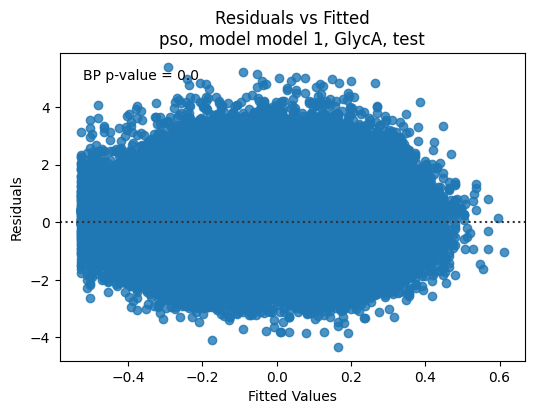

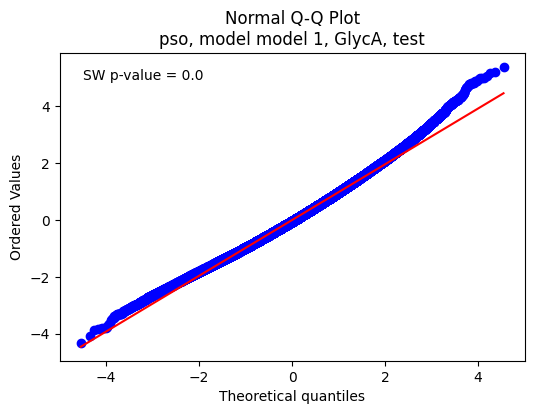

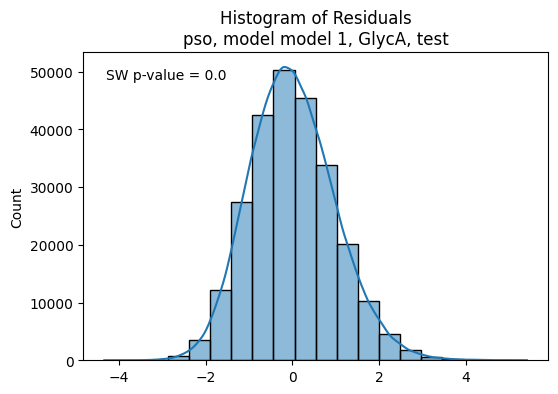

In [55]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

met_to_check = 'GlycA'

model = smf.ols(formula=f'{met_to_check}_cltrsc ~ age + sex + cent + pso', data=baseline_df, missing='drop')
result = model.fit()

# Check the result
print(result.summary())

# Run diagnostics on the model
model_diagnostics(result, 'pso', 'model 1', f'{met_to_check}', 'test')

The diagnostic result indicates heteroscedasticity, thus we need to correct the standard error and p-values using heteroscedasticity robust standard error.

In [56]:
model_robust = model.fit(cov_type='HC0')

# Check the result
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:           GlycA_cltrsc   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     273.1
Date:                Thu, 16 Oct 2025   Prob (F-statistic):               0.00
Time:                        09:43:14   Log-Likelihood:            -3.5637e+05
No. Observations:              253924   AIC:                         7.128e+05
Df Residuals:                  253900   BIC:                         7.130e+05
Df Model:                          23                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8797      0.017    -

#### 3.1.2. Logistic regression

In [57]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

met_to_check = 'GlycA'

model = smf.glm(formula=f'pso ~ age + sex + cent + {met_to_check}_cltrsc', data=baseline_df, missing='drop', family = sm.families.Binomial())
result = model.fit()

# Check the result
print(result.summary())
print(f"Odds ratio: {np.exp(result.params['GlycA_cltrsc'])}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pso   No. Observations:               253924
Model:                            GLM   Df Residuals:                   253900
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27932.
Date:                Thu, 16 Oct 2025   Deviance:                       55864.
Time:                        09:43:38   Pearson chi2:                 2.54e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002131
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.9827      0.113    -

### 3.2. Looping through all metabolites

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Define the diseases
outcomes = [#'pso', # Psoriasis
            'sev', 'non_sev', 'sev_non_sev', # Severity
            #'psa', 'non_psa', 'psa_non_psa', # Psoriatic arthritis
            #'ra', 'spa', 'uc', 'cd', 'sle', 'ad' #IMIDs
           ]

# Define the metabolites
mets_sc    = [met_name + '_sc' for met_name in met_names] # Scaled from the original 
mets_clsc  = [met_name + '_clsc' for met_name in met_names] # Scaled no outlier 
mets_cltrsc= [met_name + '_cltrsc' for met_name in met_names] # Scaled transformed no outlier 
mets_uctrsc= [met_name + '_uctrsc' for met_name in met_names] # Scaled transformed (uncleaned)

met_types       = [mets_cltrsc] #options: mets_sc, mets_clsc, mets_cltrsc, mets_uctrsc
met_types_title = ['cleaned_transformed_scaled'] #options: 'scaled', 'cleaned_scaled', 'cleaned_transformed_scaled', 'uncleaned_transformed_scaled'

# Set regression type: 'linear' for OLS or 'logistic' for logistic regression
regression_type = 'linear'

# Loop over each outcome (disease) variable
for outcome in outcomes:
    
    for j, met_type in enumerate(met_types):
        
        # Build formula depending on regression type
        if regression_type.lower() == 'logistic':
            # In logistic regression, the outcome is the dependent variable and metabolite is a predictor.
            formula_templates = [
                f"{outcome} ~ {{met}}",
                f"{outcome} ~ {{met}} + age + sex + cent",
                f"{outcome} ~ {{met}} + age + sex + cent + bmi",
                f"{outcome} ~ {{met}} + age + sex + cent + bmi + smo + meds"
            ]
        else:
            # In linear regression, the metabolite is the dependent variable.
            formula_templates = [
                "{met} ~ " + outcome,
                "{met} ~ age + sex + cent + " + outcome,
                "{met} ~ age + sex + cent + bmi + " + outcome,
                "{met} ~ age + sex + cent + bmi + smo + meds + " + outcome
            ]
        # Loop over each model type (formula)
        for i, formula_template in enumerate(formula_templates):
            print(f'Running {regression_type} regression for {outcome} - model {i} - {met_types_title[j]}')
            
            mets, coefs, lo_cis, up_cis, pvals, sample_sizes, note = [], [], [], [], [], [], []
            
            # Loop over each metabolite in the current metabolite type
            for k, met in enumerate(met_type):
                
                # Build the regression formula for the current metabolite
                formula = formula_template.format(met=met)
                
                # Fit the model while dropping rows with missing values
                if regression_type.lower() == 'logistic':
                    model = smf.glm(formula=formula, data=baseline_df, missing='drop', family = sm.families.Binomial())
                    result = model.fit()
                else:
                    model = smf.ols(formula=formula, data=baseline_df, missing='drop')
                    result = model.fit()
                    
                    # Perform BP test for detecting heteroscedasticity
                    bp_test = het_breuschpagan(result.resid, result.model.exog)
                    bp_p = round(bp_test[1], 4)
                    
                    if bp_p < 0.05:
                        model = smf.ols(formula=formula, data=baseline_df, missing='drop')
                        result = model.fit(cov_type='HC0')
                        diagnostic = 'heteroscedastic'
                    else:
                        diagnostic = 'homoscedastic'
                
                # Extract the coefficient, confidence intervals, and p-value.
                # Note: Which parameter we extract depends on regression type.
                # For logistic regression, we extract the coefficient of the metabolite,
                # whereas for linear regression we extract the coefficient of the outcome.
                if regression_type.lower() == 'logistic':
                    # For logistic regression, our key predictor is the metabolite.
                    coef = np.exp(result.params[met])
                    conf_int = np.exp(result.conf_int().loc[met])
                    pvalue = result.pvalues[met]
                else:
                    # For linear regression, we extract the coefficient for the outcome.
                    coef = result.params[outcome]
                    conf_int = result.conf_int().loc[outcome]
                    pvalue = result.pvalues[outcome]
                    
                nobs = result.nobs  # Number of observations used in the model
                
                # Append results to the lists
                mets.append(met)
                coefs.append(coef)
                lo_cis.append(conf_int[0])
                up_cis.append(conf_int[1])
                pvals.append(pvalue)
                sample_sizes.append(nobs)
                
                if regression_type.lower() == 'linear':
                    note.append(diagnostic)
                else:
                    pass
            
            # Build a summary dataframe
            if regression_type.lower() == 'linear':
                res_df = pd.DataFrame({
                    'metabolite': mets,
                    'beta': coefs,
                    'lower_ci': lo_cis,
                    'upper_ci': up_cis,
                    'pvalue': pvals,
                    'n': sample_sizes,  # Number of samples used for each regression
                    'note': note
                })
            else:
                res_df = pd.DataFrame({
                    'metabolite': mets,
                    'or': coefs,
                    'lower_ci': lo_cis,
                    'upper_ci': up_cis,
                    'pvalue': pvals,
                    'n': sample_sizes
                })
                
            # Remove the suffixes
            res_df['metabolite'] = res_df['metabolite'].str.replace(r'(_sc|_clsc|_cltrsc|_uctrsc)$', '', regex=True)
            
            # Perform FDR correction on the collected p-values using the Benjamini-Hochberg procedure
            print('Calculating FDR..')
            reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
            res_df['fdrpval'] = pvals_corrected
            res_df['fdrsig'] = reject
            
            # Sort data from the lowest to the highest p-value
            res_df = res_df.sort_values('pvalue', ascending=True)
            
            # Save the summary to an Excel file for this outcome, model type, and metabolite type
            print('Saving result..')
            filename = f'ukb[{regression_type}-{outcome}-model{i}-{met_types_title[j]}]summarystatistics.xlsx'
            res_df.to_excel(filename, index=False)

Running linear regression for sev - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for sev - model 1 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for sev - model 2 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for sev - model 3 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for non_sev - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for non_sev - model 1 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for non_sev - model 2 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for non_sev - model 3 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for sev_non_sev - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linea

##### Robust Linear Regression

3 Methods Theory: 
https://developer.nvidia.com/blog/dealing-with-outliers-using-three-robust-linear-regression-models/ 
example: https://github.com/erykml/nvidia_articles/blob/main/robust_regression.ipynb

HUBER Regressor: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html

##### Model Diagnostics

Cook's distance: https://www.scikit-yb.org/en/latest/api/regressor/influence.html#:~:text=Cook's%20Distance%20is%20a%20measure%20of%20how%20influential%20an%20instance,outliers%20in%20standard%2C%20OLS%20regression.

## 3. Baseline table

### 3.1. Recode numerical values into categorical

In [59]:
# Define function to convert codes based on a dictionary
def convcod(lst, dic):
    update = list((pd.Series(lst)).map(dic))
    return update

# Dictionary of smoking status codes
smo_codes = {0:'never', 1:'previous', 2:'current'}

# Dictionary of sex codes
sex_codes = {0:'female', 1:'male'}

# Dictionary of yes/no codes (med, pso)
oth_codes = {0:'no', 1:'yes'}

baseline_df['sex'] = convcod(baseline_df['sex'], sex_codes)
baseline_df['smo'] = convcod(baseline_df['smo'], smo_codes)
baseline_df['meds'] = convcod(baseline_df['meds'], oth_codes)
baseline_df['pso'] = convcod(baseline_df['pso'], oth_codes)
baseline_df['sev_non_sev'] = convcod(baseline_df['sev_non_sev'], oth_codes)
baseline_df['psa_non_psa'] = convcod(baseline_df['psa_non_psa'], oth_codes)
baseline_df['ad'] = convcod(baseline_df['ad'], oth_codes)
baseline_df['ra'] = convcod(baseline_df['ra'], oth_codes)
baseline_df['sle'] = convcod(baseline_df['sle'], oth_codes)
baseline_df['uc'] = convcod(baseline_df['uc'], oth_codes)
baseline_df['cd'] = convcod(baseline_df['cd'], oth_codes)
baseline_df['spa'] = convcod(baseline_df['spa'], oth_codes)

### 3.2. Characteristics table

In [60]:
!pip install tableone

In [61]:
from tableone import TableOne

cat_vars = ['sex', 'smo', 'meds']
cont_vars = ['fast', 'bmi', 'age']

outcomes = [#'pso', 
             'sev_non_sev', # Psoriasis
             'psa_non_psa', # Psoriatic arthritis
            #'ra', 'spa', 'uc', 'cd', 'sle', 'ad' #IMIDs
           ]

for k, outcome in enumerate(outcomes):
    baseline_table = TableOne(data=baseline_df[cat_vars + cont_vars + outcomes],
                              categorical = cat_vars + outcomes,
                              nonnormal = cont_vars,
                              normal_test = True, # scipy.stats.normaltest based on D'Agostino and Pearson
                              tukey_test = True, # outliers are more than 1.5 times the interquartile range from the quartiles
                              groupby = outcome,
                              missing = False
                             )
    
    baseline_table.to_excel(f'ukb_{outcome}_characteristics_table.xlsx')
    
baseline_table

Grouped by psa_non_psa                                                      
                                             Overall              None                no               yes
n                                             253924            247977              5748               199
sex, n (%)           female            137218 (54.0)     134282 (54.2)       2840 (49.4)         96 (48.2)
                     male              116706 (46.0)     113695 (45.8)       2908 (50.6)        103 (51.8)
smo, n (%)           current            26442 (10.4)      25638 (10.3)        780 (13.6)         24 (12.1)
                     never             137356 (54.1)     134710 (54.3)       2549 (44.3)         97 (48.7)
                     previous           90126 (35.5)      87629 (35.3)       2419 (42.1)         78 (39.2)
meds, n (%)          no                208932 (82.3)     204258 (82.4)       4537 (78.9)        137 (68.8)
                     yes                44992 (17.7)      43719 (17.6)       1211 (21.1)         62 (31.2)
fast, median [Q1,Q3]                   3.0 [2.0,4.0]     3.0 [2.0,4.0]     3.0 [2.0,4.0]     3.0 [3.0,5.0]
bmi, median [Q1,Q3]                 26.8 [24.2,29.9]  26.7 [24.2,29.9]  27.4 [24.7,30.7]  29.7 [26.0,33.4]
age, median [Q1,Q3]                 58.0 [50.0,63.0]  58.0 [50.0,63.0]  58.0 [51.0,63.0]  58.0 [51.0,63.0]
sev_non_sev, n (%)   None              247977 (97.7)    247977 (100.0)           0 (0.0)           0 (0.0)
                     no                   5562 (2.2)           0 (0.0)       5460 (95.0)        102 (51.3)
                     yes                   385 (0.2)           0 (0.0)         288 (5.0)         97 (48.7)
psa_non_psa, n (%)   None              247977 (97.7)    247977 (100.0)           0 (0.0)           0 (0.0)
                     no                   5748 (2.3)           0 (0.0)      5748 (100.0)           0 (0.0)
                     yes                   199 (0.1)           0 (0.0)           0 (0.0)       199 (100.0)
[1] Normality test reports non-normal
                                    distributions for: age, bmi, fast.
[2] Tukey test indicates far outliers
                                    in: bmi, fast.

TableOne documentation: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://readthedocs.org/projects/tableone/downloads/pdf/latest/
Example: https://github.com/tompollard/tableone/blob/main/tableone.ipynb

In [62]:
%%bash
dx upload *.xlsx

ID                                file-J3jGx68JZ8jkZQ3xbzb9JY4z
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              ukb[linear-non_sev-model0-cleaned_transformed_scaled]summarystatis
                                  tics.xlsx
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Thu Oct 16 10:53:13 2025
Created by                        agarham
 via the job                      job-J3jF1kjJZ8jbfpQJKy20z7f8
Last modified                     Thu Oct 16 10:53:14 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
ID                                file-J3jGx6QJZ8jQJVF0J60B4g4b
